# Agentic system for image generation - text editing


## Setting
 - Auto Reload
 - path for utils

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys, os
module_path = "../.."
sys.path.append(os.path.abspath(module_path))

## 1. Create Bedrock client

In [22]:
from pprint import pprint
from termcolor import colored
from utils import bedrock
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [23]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-5-V-2-Sonnet': 'anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-5-V-2-Sonnet-CRI': 'us.anthropic.claude-3-5-sonnet-20241022-v2:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid

## 2. LLM 정의

In [24]:
from utils.bedrock import bedrock_model
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [25]:
llm = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-V-2-Sonnet-CRI"),
    #model_id=bedrock_info.get_model_id(model_name="Nova-Pro-CRI"),
    bedrock_client=boto3_bedrock,
    stream=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    inference_config={
        'maxTokens': 1024,
        'stopSequences': ["\n\nHuman"],
        'temperature': 0.01,
        #'topP': ...,
    }
    #additional_model_request_fields={"top_k": 200}
)

In [26]:
image_generation_model = bedrock_model(
    model_id=bedrock_info.get_model_id(model_name="Nova-Canvas"),
    bedrock_client=boto3_bedrock
)

## 3. Analysis

In [27]:
import io
import time
import json
import pprint
import base64
import traceback
from PIL import Image
from termcolor import colored
import matplotlib.pyplot as plt

from textwrap import dedent
from utils.bedrock import bedrock_utils
from typing import TypedDict
from src.genai_anaysis import llm_call
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig

In [28]:
class TimeMeasurement:
    def __init__(self):
        self.start_time = None
        self.measurements = {}

    def start(self):
        self.start_time = time.time()

    def measure(self, section_name):
        if self.start_time is None:
            raise ValueError("start() 메서드를 먼저 호출해야 합니다.")
        
        end_time = time.time()
        elapsed_time = end_time - self.start_time
        self.measurements[section_name] = elapsed_time
        self.start_time = end_time  # 다음 구간 측정을 위해 시작 시간 재설정

    def reset(self, ):
        self.measurements = {}

    def print_measurements(self):
        for section, elapsed_time in self.measurements.items():
            #print(f"{section}: {elapsed_time:.5f} 초")
            print(colored (f"\nelapsed time: {section}: {elapsed_time:.5f} 초", "red"))

### 3.1 Agent state 

In [29]:
class GraphState(TypedDict):
    ask: str
    task_type: str
    ask_repo: str
    prompt_components: dict
    image_prompt: dict
    image_model: str
    generated_img_path: str
    suggestions: str
    retouch: str
    retry_count: int
    control_image_needed: str
    control_mode: str
    prev_node: str

In [31]:
class genai_analyzer():

    def __init__(self, **kwargs):

        self.llm=kwargs["llm"]
        self.image_generation_model = kwargs["image_generation_model"]
        self.state = GraphState

        self.llm_caller = llm_call(
            llm=self.llm,
            verbose=False
        ) 

        self._graph_definition()
        self.messages = []

        self.timer = TimeMeasurement()

    def _get_string_from_message(self, message):
        return message["content"][0]["text"]

    def _get_message_from_string(self, role, string, imgs=None):
        
        message = {
            "role": role,
            "content": []
        }
        
        if imgs is not None:
            for img in imgs:
                img_message = {
                    "image": {
                        "format": 'png',
                        "source": {"bytes": img}
                    }
                }
                message["content"].append(img_message)
        
        message["content"].append({"text": dedent(string)})

        return message
    
    def _png_to_bytes(self, file_path):
        try:
            with open(file_path, "rb") as image_file:
                # 파일을 바이너리 모드로 읽기
                binary_data = image_file.read()
                
                # 바이너리 데이터를 base64로 인코딩
                base64_encoded = base64.b64encode(binary_data)
                
                # bytes 타입을 문자열로 디코딩
                base64_string = base64_encoded.decode('utf-8')
                
                return binary_data, base64_string
                
        except FileNotFoundError:
            return "Error: 파일을 찾을 수 없습니다."
        except Exception as e:
            return f"Error: {str(e)}"

    def show_save_image(self, base64_string):
        try:
            
            # base64 문자열을 디코딩하여 바이너리 데이터로 변환
            image_data = base64.b64decode(base64_string)
            
            # 바이너리 데이터를 이미지로 변환
            image = Image.open(io.BytesIO(image_data))
            
            # matplotlib을 사용하여 이미지 표시
            plt.imshow(image)
            plt.axis('off')  # 축 제거
            plt.show()
            
            # save images
            img_path = './generated_imgs/GENERATED_IMAGE.png'
            image.save(img_path, "PNG")
            
            return img_path
            
        except Exception as e:
            print(f"Error: 이미지를 표시하는 데 실패했습니다. {str(e)}")
            
    def _body_generator(self, image_prompt, condition_image=None, control_mode=None, condition_strength=0.2):
                
        body_dict = {
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": image_prompt["main_prompt"],
                "negativeText": image_prompt["negative_prompt"]
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 512,
                "width": 512,
                "cfgScale": 9.5,
                "seed": 1,
                "quality": "premium" #"standard" | "premium",
            }
        }

        if condition_image is not None:
            body_dict["textToImageParams"]["conditionImage"] = condition_image # Base64 encoded image
            body_dict["textToImageParams"]["controlMode"] = control_mode #"SEGMENTATION" # "CANNY_EDGE" | "SEGMENTATION", 
            body_dict["textToImageParams"]["controlStrength"] = condition_strength # 0 to 1.0

        return json.dumps(body_dict)

    def get_messages(self, ):
        return self.messages
        
    def _graph_definition(self, **kwargs):

        def ask_reformulation(state):

            self.timer.start()
            self.timer.reset()
            
            print("---ASK REFORMULATION---")
            ask = state["ask"]
            image_prompt, suggestions = state.get("image_prompt", "None"), state.get("suggestions", "None")
            messages = []
            
            print ("image_prompt", image_prompt)
            print ("suggestions", suggestions)
            
            system_prompts = dedent(
                '''
                <task>
                주어진 사용자의 ask, main_prompt, negative_prompt를 모두 고려하여, 하나의 ask로 재 생성합니다.
                </task>

                <instruction>
                1. 전체적으로 main_prompt의 내용을 유지하되, ask의 내용이 main_prompt와 반대 혹은 상충되는 부분이 있다면 그 부분은 ask의 내용을 우선 하세요.  
                2. 전체적으로 negative_prompt를 내용을 유지하되, ask의 내용이 negative_prompt를 반대 혹은 상충되는 부분이 있다면 그 부분은 ask의 내용을 우선 하세요.
                3. 전체적으로 main_prompt의 내용을 유지하되, suggestions 내용이 main_prompt와 반대 혹은 상충되는 부분이 있다면 그 부분은 suggestions 내용을 우선 하세요. 
                4. 전체적으로 negative_prompt를 내용을 유지하되, suggestions 내용이 negative_prompt를 반대 혹은 상충되는 부분이 있다면 그 부분은 suggestions 내용을 우선 하세요.
                5. consideration을 고려하여, control image의 필요성 여부를 판단하세요 ('true'/'false'). 
                5. 응답에 ```json``` 을 사용하지 않습니다.
                
                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {
                    "ask_repo": "재 생성된 ask"
                    "control_image_needed": "control image 필요 여부 ('true'/'false')"
                    "control_mode": "('CANNY_EDGE/SEGMENTATION') (if 'true')",
                }
                </output_format>

                <consideration>
                Based on the user's request, determine if a control image is needed ('true'/'false').
                Also suggest appropriate control mode and strength if control image is needed.

                Consider the following criteria:
                
                For control image necessity (true/false):
                1. If the request requires maintaining exact facial structure/features = true
                2. If the request is about precise layout/composition preservation = true
                3. If the request only involves style/color changes without structural preservation = false
                
                For control mode suggestion (if true):
                1. CANNY_EDGE: Best for
                  - Keeping exact facial features
                  - Preserving precise contours and edges
                  - When structural accuracy is critical
                
                2. SEGMENTATION: Best for
                  - General layout preservation with more creative freedom
                  - Style transfer while keeping rough composition
                  - When exact edge matching isn't critical
                  
                Please provide your assessment as a single word answer: 'true' or 'false', based on these criteria.
                </consideration>
                
                '''
            )
            
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                Here is main_prompt: <main_prompt>{main_prompt}</main_prompt>
                Here is negative_prompt: <negative_prompt>{negative_prompt}</negative_prompt>
                Here is suggestions: <suggestions>{suggestions}</suggestions>
                '''
            )
            context = {
                "ask": ask,
                "main_prompt": image_prompt["main_prompt"] if image_prompt != "None" else "None",
                "negative_prompt": image_prompt["negative_prompt"] if image_prompt != "None" else "None",
                "suggestions": suggestions if suggestions != "None" else "None"
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
            
            results = eval(resp['text'])
            ask_repo = results["ask_repo"]
            control_image_needed, control_mode = results["control_image_needed"], results["control_mode"]
            
            return self.state(ask_repo=ask_repo, control_image_needed=control_image_needed, control_mode=control_mode, prev_node="ASK_REFORMULATION")
        
        def check_readness_prompt_generation(state):

            print("---CHECK READNESS FOR PROMPT GENERATION---")
            ask_repo = state["ask_repo"]
            image_prompt = state.get("image_prompt", "None")
            messages = []
            print ("image_prompt", image_prompt)
            
            system_prompts = dedent(
                '''
                <task>
                사용자의 이미지 생성 요청(ask)을 분석하여 6가지 핵심 구성 요소(subject, action, environment, lighting, style, camera_position)의 존재 여부를 확인하고 해당 내용을 추출합니다.
                </task>

                <instruction>
                1. 사용자의 요청에서 다음 구성 요소들을 식별하세요:
                   - subject: 주요 대상이나 피사체
                   - action: 동작이나 상태 묘사
                   - environment: 배경이나 장소
                   - lighting: 조명이나 빛 묘사
                   - style: 예술 스타일이나 표현 방식
                   - camera_position: 촬영 각도나 거리
                2. 각 요소에 대해:
                   - 명시적으로 언급되었는지 확인
                   - 언급된 경우, 관련된 텍스트를 추출
                3. 발견된 요소와 누락된 요소를 명확히 구분하여 보고하세요.
                4. 응답에 ```json``` 을 사용하지 않습니다.
                </instruction>

                <output_format>
                JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {
                    "components": {
                        "subject": {
                            "content": "발견된 텍스트 또는 null"
                        },
                        "action": {
                            "content": "발견된 텍스트 또는 null"
                        },
                        "environment": {
                            "content": "발견된 텍스트 또는 null"
                        },
                        "lighting": {
                            "content": "발견된 텍스트 또는 null"
                        },
                        "style": {
                            "content": "발견된 텍스트 또는 null"
                        },
                        "camera_position": {
                            "content": "발견된 텍스트 또는 null"
                        }
                    }
                }
                </output_format>

                <examples>
                입력: "해변가에서 일몰을 배경으로 서핑하는 사람을 그려줘"

                출력:
                {
                    "components": {
                        "subject": {
                            "content": "서핑하는 사람"
                        },
                        "action": {
                            "content": "서핑하는"
                        },
                        "environment": {
                            "content": "해변가"
                        },
                        "lighting": {
                            "content": "일몰"
                        },
                        "style": {
                            "content": "null"
                        },
                        "camera_position": {
                            "content": "null"
                        }
                    }
                }
                </examples>

                <considerations>
                - content는 요청에서 발견된 실제 텍스트를 최대한 원문 그대로 포함합니다.
                - 구성 요소가 없는 경우 content는 null로 표시합니다.
                </considerations>
                '''
            )
                
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                Here is main_prompt: <main_prompt>{main_prompt}</main_prompt>
                Here is negative_prompt: <negative_prompt>{negative_prompt}</negative_prompt>
                '''
            )
            context = {
                "ask": ask_repo,
                "main_prompt": image_prompt["main_prompt"] if image_prompt != "None" else "None",
                "negative_prompt": image_prompt["negative_prompt"] if image_prompt != "None" else "None"                
            }
            user_prompts = user_prompts.format(**context)
                       
            message = self._get_message_from_string(role="user", string=user_prompts)
            self.messages.append(message)
            messages.append(message)
            
            resp, ai_message = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages.append(ai_message)
            
            results = eval(resp['text'])
            prompt_components = results["components"]
            
            return self.state(prompt_components=prompt_components, prev_node="CHECK_READNESS_PROMPT_GENERATION")
                
        def prompt_generation_for_image(state):

            print("---PROMPT GENERATION FOR IMAGE---")
            ask_repo, prompt_components, image_model,  = state["ask_repo"], state["prompt_components"], state["image_model"]
            image_prompt = state.get("image_prompt", "None")
            messages = []
            
            system_prompts = dedent(
                '''
                당신은 이미지 생성 프롬프트 개선 에이전트입니다.
                사용자의 요청과 이미 분석된 6가지 구성 요소를 활용하여 효과적인 이미지 생성이 가능하도록 최적화된 프롬프트를 생성하는 것이 당신의 임무입니다.

                <task>
                주어진 사용자 요청(ask)와 파악된 구성 요소들(subject, action, environment, lighting, style, camera_position)을 활용하여 사용자의 이미지 생성 요청을 이미지 캡션 형태로 재구성합니다.
                이미지 생성 모델은 추론이나 명령을 해석하는 능력이 없으므로, 명령문이나 대화체가 아닌 이미지 캡션 형식으로 프롬프트를 작성해야 합니다.
                반드시 선택된 이미지 생성 모델 {image_model}기반의 프롬프트로 작성합니다.
                각 이미지 생성 모델의 특성을 고려하여 프롬프트를 최적화합니다:

                1. nova-canvas:
                  - 명확하고 구체적인 시각적 설명 사용
                  - 기술적인 세부 사항 포함 가능 (해상도, 품질 등)
                  - negative prompt 지원

                2. stable-diffusion:
                  - 아티스트 이름, 스타일 참조 활용
                  - 세부적인 스타일 키워드 사용
                  - 품질/세부 사항 관련 키워드 활용
                  - negative prompt 지원
                  
                </task>

                <instruction>
                1. 이전 단계에서 파악된 구성 요소들을 확인하세요.

                2. 선택된 이미지 생성 모델의 특성을 고려하여:
                  - 해당 모델에 최적화된 키워드와 구문을 선택합니다
                  - 모델의 강점을 활용할 수 있는 표현을 사용합니다
                  - 모델별 특수 파라미터나 구문이 필요한 경우 추가합니다
                  - 선택된 모델의 문법과 구문을 준수합니다
                  
                3. 파악된 요소들을 활용하여:
                  - 명령문이나 대화체를 제거합니다
                  - 이미지 캡션 형식으로 재구성합니다
                  - 캡션은 자연스러운 설명문 형태가 되도록 합니다

                4. 재구성된 프롬프트를 생성하세요:
                  - 영어로 작성합니다
                  - 구체적이고 묘사적인 표현을 사용합니다
                  - 각 요소들이 자연스럽게 연결되도록 합니다
                
                5. Avoid using negating words (“no”, “not”, “without”, etc.) in your text and negativeText values.
                   For example, if you do not want mirrors in an image, instead of including "no mirrors" or "without mirrors" in the text field, use the word "mirrors" in the negativeText field.

                6. keep the generated prompt within 1024 characters.
                </instruction>

                <output_format>
                {{
                    "image_prompt":
                        {{
                            "main_prompt": "재구성된 이미지 캡션 형태의 프롬프트",
                            "negative_prompt": "제외할 요소들"
                        }}
                }}
                </output_format>

                <examples>
                입력 요소들:
                <subject>"subject"</subject>,
                <action>"action"</action>,
                <environment>"environment"</environment>,
                <lighting>"lighting"</lighting>,
                <style>"style"</style>,
                <camera_position>"camera_position"</camera_position>
    
                출력:
                {{
                    "image_prompt":
                        {{
                            "main_prompt": "A surfer riding waves at a beach during golden sunset, vibrant orange sky reflecting on the ocean waters",
                            "negative_prompt": "bad quality, low resolution, blurry, oversaturated"
                        }}
                }}

                </examples>

                <considerations>
                - 항상 이미지 캡션 형식을 사용합니다
                - 명령문("~해줘", "~그려줘" 등)을 제거합니다
                - 대화체 표현을 제거합니다
                - 모든 설명은 영어로 변환합니다
                - 구체적이고 묘사적인 표현을 사용합니다
                - 각 요소들이 자연스럽게 연결되도록 작성합니다
                </considerations>
                '''
            )
            
            context = {"image_model": image_model}
            system_prompts = system_prompts.format(**context)
            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            
            user_prompts = dedent(
                '''
                Here is user's ask: <ask>{ask}</ask>
                Here is extracted components: <subject>{subject}</subject>,\n<action>{action}</action>,\n<environment>{environment}</environment>\n<lighting>{lighting}</lighting>\n<style>{style}</style>\n<camera_position>{camera_position}</camera_position>
                '''
            )
            context = {
                "ask": ask_repo,
                "subject": prompt_components["subject"],
                "action": prompt_components["action"],
                "environment": prompt_components["environment"],
                "lighting": prompt_components["lighting"],
                "style": prompt_components["style"],
                "camera_position": prompt_components["camera_position"]
            }
            user_prompts = user_prompts.format(**context)
            
            message = self._get_message_from_string(role="user", string=user_prompts)            
            self.messages.append(message)
            messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = eval(resp['text'])
            image_prompt = results["image_prompt"]

            return self.state(image_prompt=image_prompt, prev_node="PROMPT_GENERATION_FOR_IMAGE")
        
        def image_generation(state):
            
            print("---IMAGE GENERATION---")
            image_prompt = state["image_prompt"]
            control_image_needed, control_mode = state["control_image_needed"], state["control_mode"]
            generated_img_path = state.get("generated_img_path", None)
            print ("generated_img_path", generated_img_path)

            #img_bytes, img_base64 = self._png_to_bytes(generated_img_path)
            #condition_image = img_base64 if (control_image_needed == "true" and generated_img_path is not None) else None

            if control_image_needed == "true":
                if generated_img_path is not None:
                    img_bytes, img_base64 = self._png_to_bytes(generated_img_path)
                    condition_image = img_base64
                else:
                    condition_image = None
            else:
                condition_image = None
            
            body = self._body_generator(
                image_prompt,
                condition_image,
                control_mode,
                condition_strength=0.2
            )
            
            response = self.image_generation_model.bedrock_client.invoke_model(
                body=body,
                modelId=self.image_generation_model.model_id
            )
            response_body = json.loads(response.get("body").read())
            base64_image = response_body.get("images")[0]
            generated_img_path = self.show_save_image(base64_image)
                        
            return self.state(generated_img_path=generated_img_path, prev_node="IMAGE_GENERATION")

        def reflection(state):

            print("---REFLECTION---")
            ask_repo, generated_img_path = state["ask_repo"], state["generated_img_path"]
            retry_count = state.get("retry_count", 0)
            messages = []
            
            ask_repo, prompt_components, generated_img_path = state["ask_repo"], state["prompt_components"], state["generated_img_path"]
            messages = []
            
            system_prompts = dedent(
                '''
                <task>
                이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
                </task>

                <instruction>
                1. 사용자의 요청(ask)가 이미지에 모두 포함이 되어 있는지 확인하세요.
                2. 6가지 핵심 구성 요소(subject, action, environment, lighting, style, camera_position)관점에서 평가하세요.
                3. 평가를 기반으로 이미지 수정 여부 (retouch)를 결정합니다 ('true'/'false'). 
                4. 만약 사용자 요청과 다른 부분이 있다면 수정을 위한 suggestions을 2개 이하로 하세요.
                5. suggestions에는 수정 사항들만 나열합니다.
                6. suggestions는 저작권이 있는 컨텐츠는 사용하지 않으며 한글로 작성합니다.
                7. DO NOT use ```json``` in response.
                </instruction>

                <output_format>
                 JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
                {{
                    "retouch: "image regeneration 여부 ('true'/'false')"
                    "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
                }}
                </output_format>

                <considerations>
                - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
                - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
                - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
                - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
                - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
                </considerations>

                <restrictions>
                - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
                - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
                - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
                - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
                </restrictions>
                '''
             )

            system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)
            user_prompts = dedent(
                '''
                Here is the question: <ask>{ask}</ask>
                Here is extracted components: <subject>{subject}</subject>,\n<action>{action}</action>,\n<environment>{environment}</environment>\n<lighting>{lighting}</lighting>\n<style>{style}</style>\n<camera_position>{camera_position}</camera_position>
                '''
            )

            context = {
                "ask": ask_repo,
                "subject": prompt_components["subject"],
                "action": prompt_components["action"],
                "environment": prompt_components["environment"],
                "lighting": prompt_components["lighting"],
                "style": prompt_components["style"],
                "camera_position": prompt_components["camera_position"]
            }
            user_prompts = user_prompts.format(**context)
            
            img_bytes, img_base64 = self._png_to_bytes(generated_img_path)
            message = self._get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
            messages.append(message)
            self.messages.append(message)

            resp, ai_message = self.llm_caller.invoke(messages=self.messages, system_prompts=system_prompts)
            self.messages.append(ai_message)

            results = eval(resp['text'])            
            suggestions = results["suggestions"]
            retouch, suggestions = results["retouch"], results["suggestions"]
            if retouch == "true": retry_count += 1
            
            return self.state(retouch=retouch, suggestions=suggestions, retry_count=retry_count, prev_node="REFLECTION")

        def should_image_regeneration(state):
            
            print("---IMAGE CHECKER---")
            retouch, retry_count = state["retouch"], state["retry_count"]
            
            if retry_count <= 2 and retouch == "true":
                print ("---[REFLECTION] GO TO IMAGE REGENERATION---")
                print ("retry_count: ", retry_count)
                return "regeneration"
            else:
                print ("---GO TO SHOW UP---")
                return "continue"
            
        # langgraph.graph에서 StateGraph와 END를 가져옵니다.
        workflow = StateGraph(self.state)

        # Todo 를 작성합니다.
        workflow.add_node("ask_reformulation", ask_reformulation)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("check_readness_prompt_generation", check_readness_prompt_generation)  # 이미지 생성을 위해 필요한 요소들이 준비되었는지 확인합니다.
        workflow.add_node("prompt_generation_for_image", prompt_generation_for_image)  # 요청을 이미지 생성용 프롬프트로 수정하는 노드를 추가합니다.
        workflow.add_node("image_generation", image_generation)  # 이미지 생성하는 노드를 추가합니다.
        workflow.add_node("reflection", reflection)  # 사용자의 요청에 맞게 이미지가 생성 되었는지 확인힙니다.
        
        workflow.add_edge("ask_reformulation", "check_readness_prompt_generation")
        workflow.add_edge("check_readness_prompt_generation", "prompt_generation_for_image")
        workflow.add_edge("prompt_generation_for_image", "image_generation")
        workflow.add_edge("image_generation", "reflection")
        workflow.add_conditional_edges(
            "reflection",
            # 에이전트 결정 평가
            should_image_regeneration,
            {
                # 도구 노드 호출
                "continue": END,
                "regeneration": "ask_reformulation",
            },
        )
        #workflow.add_edge("image_grading", END)

        # 시작점을 설정합니다.
        workflow.set_entry_point("ask_reformulation")

        # 기록을 위한 메모리 저장소를 설정합니다.
        memory = MemorySaver()

        # 그래프를 컴파일합니다.
        self.app = workflow.compile(checkpointer=memory)        
        self.config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "Text2Image"})

    def invoke(self, **kwargs):
        
        inputs = self.state(ask=kwargs["ask"], image_model=kwargs["image_model"])
        # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
        for output in self.app.stream(inputs, self.config):
            # 출력된 결과에서 키와 값을 순회합니다.
            for key, value in output.items():
                # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
                pprint.pprint(f"\nOutput from node '{key}':")
                pprint.pprint("---")
                # 출력 값을 예쁘게 출력합니다.
                pprint.pprint(value, indent=2, width=80, depth=None)
                
                #pprint.pprint(self.messages)
                
            # 각 출력 사이에 구분선을 추가합니다.
            pprint.pprint("\n---\n")
            
    
    def show_graph(self, ):
        
        from IPython.display import Image, display

        try:
            display(
                Image(self.app.get_graph(xray=True).draw_mermaid_png())
            )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
            # xray=True는 추가적인 세부 정보를 포함합니다.
        except:
            # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
            pass

            

In [32]:
analyzer = genai_analyzer(
    llm=llm,
    image_generation_model=image_generation_model
)

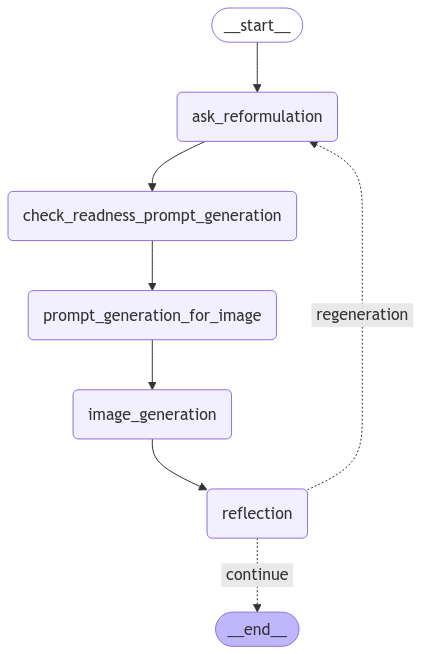

In [33]:
analyzer.show_graph()

---ASK REFORMULATION---
image_prompt None
suggestions None
{
_repo": "A color photograph of a Librarian, headshot, high-quality",
_image_needed": "false",
control_mode": ""
"\nOutput from node 'ask_reformulation':"
'---'
{ 'ask_repo': 'A color photograph of a Librarian, headshot, high-quality',
  'control_image_needed': 'false',
  'control_mode': '',
  'prev_node': 'ASK_REFORMULATION'}
'\n---\n'
---CHECK READNESS FOR PROMPT GENERATION---
image_prompt None
{
components": {
"subject": {
": "Librarian"ontent
        },
"action": {
": "null"   "content
        },
": {    "environment
"content": "null"
        },
": {    "lighting
"content": "null"
},      
style": {
 "color photograph, high-quality"
        },
"camera_position": {
"content": "headshot"
}       
    }
"\nOutput from node 'check_readness_prompt_generation':"
'---'
{ 'prev_node': 'CHECK_READNESS_PROMPT_GENERATION',
  'prompt_components': { 'action': {'content': 'null'},
                         'camera_position': {'content': 

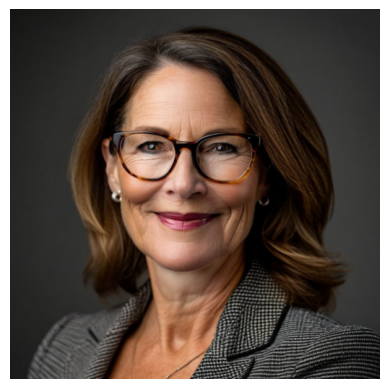

"\nOutput from node 'image_generation':"
'---'
{ 'generated_img_path': './generated_imgs/GENERATED_IMAGE.png',
  'prev_node': 'IMAGE_GENERATION'}
'\n---\n'
---REFLECTION---
{
retouch": "false",
suggestions": []
---IMAGE CHECKER---
---GO TO SHOW UP---
"\nOutput from node 'reflection':"
'---'
{ 'prev_node': 'REFLECTION',
  'retouch': 'false',
  'retry_count': 0,
  'suggestions': []}
'\n---\n'


In [34]:

analyzer.invoke(
    ask=dedent("A color photograph of a Librarian, headshot, high-quality."),
    image_model="nova-canvas"
)

---ASK REFORMULATION---
image_prompt {'main_prompt': 'Professional headshot of a librarian, wearing glasses and professional attire, clear facial features, sharp details, studio lighting, color photograph, 8k resolution, professional photography, detailed skin texture', 'negative_prompt': 'blurry, low resolution, poor lighting, distorted features, oversaturated colors, cartoon style, illustration, anime'}
suggestions []
{
ask_repo": "Professional headshot of a male librarian without glasses, wearing professional attire, clear facial features, sharp details, studio lighting, color photograph, 8k resolution, professional photography, detailed skin texture",
"control_image_needed": "false",
"control_mode": ""
"\nOutput from node 'ask_reformulation':"
'---'
{ 'ask_repo': 'Professional headshot of a male librarian without glasses, '
              'wearing professional attire, clear facial features, sharp '
              'details, studio lighting, color photograph, 8k resolution, '
         

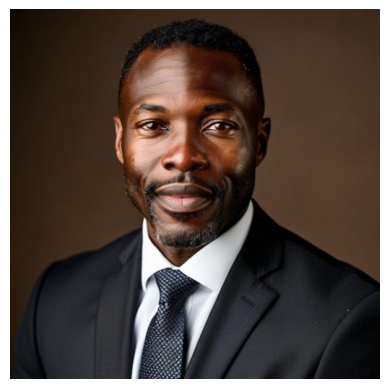

"\nOutput from node 'image_generation':"
'---'
{ 'generated_img_path': './generated_imgs/GENERATED_IMAGE.png',
  'prev_node': 'IMAGE_GENERATION'}
'\n---\n'
---REFLECTION---
{
retouch": "false",
suggestions": []
---IMAGE CHECKER---
---GO TO SHOW UP---
"\nOutput from node 'reflection':"
'---'
{ 'prev_node': 'REFLECTION',
  'retouch': 'false',
  'retry_count': 0,
  'suggestions': []}
'\n---\n'


In [35]:
analyzer.invoke(
    ask=dedent("남자로 변경하고, 안경은 제거 해줘"),
    image_model="nova-canvas"
)

In [36]:
analyzer.invoke(
    ask=dedent("전체 몸이 다 보이도록 변경해줘"),
    image_model="nova-canvas"
)

---ASK REFORMULATION---
image_prompt {'main_prompt': 'Professional headshot of a male librarian wearing a dark suit and tie, clear facial features, sharp details, studio lighting with soft shadows, color photograph, 8k resolution, professional photography, detailed skin texture, well-groomed appearance', 'negative_prompt': 'glasses, blurry, low resolution, poor lighting, distorted features, oversaturated colors, cartoon style, illustration, anime, female features'}
suggestions []
{
ask_repo": "Full body professional portrait of a male librarian wearing a dark suit and tie, clear facial features, sharp details, studio lighting with soft shadows, color photograph, 8k resolution, professional photography, detailed skin texture, well-groomed appearance, standing pose",
_image_needed": "true",
control_mode": "CANNY_EDGE"
"\nOutput from node 'ask_reformulation':"
'---'
{ 'ask_repo': 'Full body professional portrait of a male librarian wearing a '
              'dark suit and tie, clear facia

TypeError: 'NoneType' object is not subscriptable

In [ ]:
analyzer.invoke(
    ask=dedent("high-end camera, shot on Canon EOS R5, 스튜디오 촬영, photorealistic, 한 남성 모델이 세탁기 옆에서 세탁기 광고를 촬영하는 모습"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("창밖에서 따듯한 햇살이 비추는 오전, 커피 한잔을 미술용 테이블에 올려놓고, 오늘은 어떤 하루를 보낼지 생각하는 우아하고 예쁜 동양인 여성 미술 원장, realistic editorial photo"),
    image_model="nova-canvas"
)

In [ ]:
bb

In [ ]:
analyzer.invoke(
    ask=dedent("사람이 창문을 보고 서 있는 모습으로 변경해줘"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("여성이 서있지 않고 앉아있는 자세로 촬영되어 있어 'standing'과 차이 가 있습니다. 이 부분을 수정해서 생성해 주세요"),
    image_model="nova-canvas"
)

In [ ]:
analyzer.invoke(
    ask=dedent("벽면의 아트워크와 디자인 요소들이 이미지에서 보이지 않으므로 벽면 장식을 추가하면 좋겠습니다"),
    image_model="nova-canvas"
)

In [ ]:
 def _get_message_from_string(role, string, imgs=None):
        
    message = {
        "role": role,
        "content": []
    }

    if imgs is not None:
        for img in imgs:
            img_message = {
                "image": {
                    "format": 'png',
                    "source": {"bytes": img}
                }
            }
            message["content"].append(img_message)

    message["content"].append({"text": dedent(string)})

    return message

def _png_to_bytes( file_path):
    try:
        with open(file_path, "rb") as image_file:
            # 파일을 바이너리 모드로 읽기
            binary_data = image_file.read()

            # 바이너리 데이터를 base64로 인코딩
            base64_encoded = base64.b64encode(binary_data)

            # bytes 타입을 문자열로 디코딩
            base64_string = base64_encoded.decode('utf-8')

            return binary_data, base64_string

    except FileNotFoundError:
        return "Error: 파일을 찾을 수 없습니다."
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
#img_path = state["img_path"] # PNG 파일 경로
img_path = "./generated_imgs/GENERATED_IMAGE.png"
messages = []  
llm_caller = llm_call(
    llm=llm,
    verbose=False
)
ask_reformulation = "어두운 하늘의 구름을 그려줘"

system_prompts = dedent(
    '''
    <task>
    이미지 생성 요청과 생성된 이미지 간의 부합도를 평가하는 에이전트 역할 수행
    </task>

    <instruction>
    1. 사용자의 이미지 생성 요청을 다음 기준으로 분석하세요:
       - 요청된 주요 객체나 대상
       - 구체적인 시각적 특성 (색상, 크기, 형태 등)
       - 구도나 배치에 대한 요구사항
       - 스타일이나 분위기에 대한 설명
       - 특수한 효과나 기법에 대한 요청

    2. 생성된 이미지를 다음 측면에서 평가하세요:
       - 요청된 주요 객체의 존재 여부와 정확성
       - 시각적 특성의 구현 정도
       - 구도와 배치의 일치도
       - 전반적인 스타일과 분위기의 부합성
       - 특수 효과나 기법의 적용 상태

    3. 평가 결과를 수치화하여 다음 항목별로 점수를 매기세요:
       - 객체 정확도 (0-20점)
       - 시각적 특성 구현도 (0-20점)
       - 구도/배치 일치도 (0-20점)
       - 스타일/분위기 부합도 (0-20점)
       - 전반적 완성도 (0-20점)
    4. DO NOT use ```json``` in response.
    </instruction>

    <scoring_criteria>
    - 객체 정확도 (20점)
      * 20점: 모든 요청 객체가 정확히 표현됨
      * 15점: 주요 객체는 있으나 일부 세부사항 누락
      * 10점: 일부 주요 객체 누락 또는 부정확
      * 5점: 대부분의 객체가 부정확하거나 누락
      * 0점: 요청 객체와 전혀 다른 내용

    - 시각적 특성 구현도 (20점)
      * 20점: 모든 시각적 특성이 정확히 구현됨
      * 15점: 대부분의 특성이 구현되었으나 일부 미흡
      * 10점: 주요 특성만 부분적으로 구현
      * 5점: 대부분의 특성이 미구현
      * 0점: 요청된 특성과 전혀 다름

    - 구도/배치 일치도 (20점)
      * 20점: 요청된 구도와 완벽히 일치
      * 15점: 전반적 구도는 유사하나 일부 차이
      * 10점: 기본적인 구도만 일치
      * 5점: 구도가 크게 다름
      * 0점: 전혀 다른 구도

    - 스타일/분위기 부합도 (20점)
      * 20점: 의도된 스타일과 분위기를 완벽히 구현
      * 15점: 유사한 스타일과 분위기 표현
      * 10점: 부분적으로만 의도된 분위기 표현
      * 5점: 의도와 다른 분위기
      * 0점: 전혀 다른 스타일과 분위기

    - 전반적 완성도 (20점)
      * 20점: 전문적 수준의 완성도
      * 15점: 양호한 완성도
      * 10점: 기본적인 완성도
      * 5점: 미흡한 완성도
      * 0점: 매우 낮은 완성도
    </scoring_criteria>

    <output_format>
     JSON 형식으로 다음 정보를 포함하여 응답하세요. 절대 JSON 포멧 외 텍스트는 넣지 마세요.:
    {{
       "score": "일치도 스코어",
       "suggestions": "사용자 요청에 더욱 부합하기 위해 개선해야 할 사항"
    }}
    </output_format>

    <considerations>
    - 요청 사항이 모호한 경우, 일반적인 기준에서 합리적으로 해석하여 평가합니다.
    - 기술적 제약으로 인한 한계는 감안하여 평가합니다.
    - 주관적 요소(예: 분위기, 감정)는 일반적인 인식을 기준으로 평가합니다.
    - 평가는 건설적이고 객관적인 관점에서 이루어져야 합니다.
    - 개선점은 구체적이고 실행 가능한 제안으로 제시합니다.
    </considerations>

    <restrictions>
    - 개인적인 취향이나 선호도에 기반한 평가는 지양합니다.
    - 비윤리적이거나 부적절한 내용에 대한 평가는 거부합니다.
    - 기술적으로 구현 불가능한 요소에 대해서는 감점하지 않습니다.
    - 저작권이나 윤리적 문제가 있는 요청에 대해서는 평가를 중단합니다.
    </restrictions>

    이 프롬프트는 이미지 생성 요청과 실제 생성된 이미지 간의 일치도를 체계적이고 객관적으로 평가할 수 있도록 구성되었습니다.
    각 평가 항목에 대한 명확한 기준을 제시하고, 정량적인 점수와 정성적인 평가를 함께 제공하여 종합적인 평가가 가능하도록 했습니다.
    '''
 )

system_prompts = bedrock_utils.get_system_prompt(system_prompts=system_prompts)

user_prompts = dedent(
    '''
    Here is the question: <ask>{ask}</ask>
    '''
)

context = {
    "ask": ask_reformulation
}
user_prompts = user_prompts.format(**context)

img_bytes, img_base64 = _png_to_bytes(img_path)
message = _get_message_from_string(role="user", string=user_prompts, imgs=[img_bytes])
messages.append(message)

resp, messages_updated = llm_caller.invoke(messages=messages, system_prompts=system_prompts)